# Santander Customer Transaction Prediction

In [37]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, confusion_matrix
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns


train_df = pd.read_csv("../project/data/train_small.csv", header=None)
test_df = pd.read_csv("../project/data/test_small.csv")

train_df.columns = list([test_df.columns[0],"target",*test_df.columns[1:]])

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Data Preprocessing

In [2]:
response = np.array(train_df['target'])
features = np.array(train_df.iloc[:,2:])
features_list = list(train_df.iloc[:,2:].columns)

from sklearn.model_selection import train_test_split
train_features, test_features, train_response, test_response = train_test_split(features, response, test_size = 0.25, random_state = 42)


In [14]:
print("train: ", 100*train_response.sum()/train_response.size,"   test: ", 100*test_response.sum()/test_response.size)

train:  10.009135548703894    test:  9.865829289180702


## Feature Selection 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, random_state = 42, verbose = 10,n_jobs = -1)

rf.fit(train_features, train_response)



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


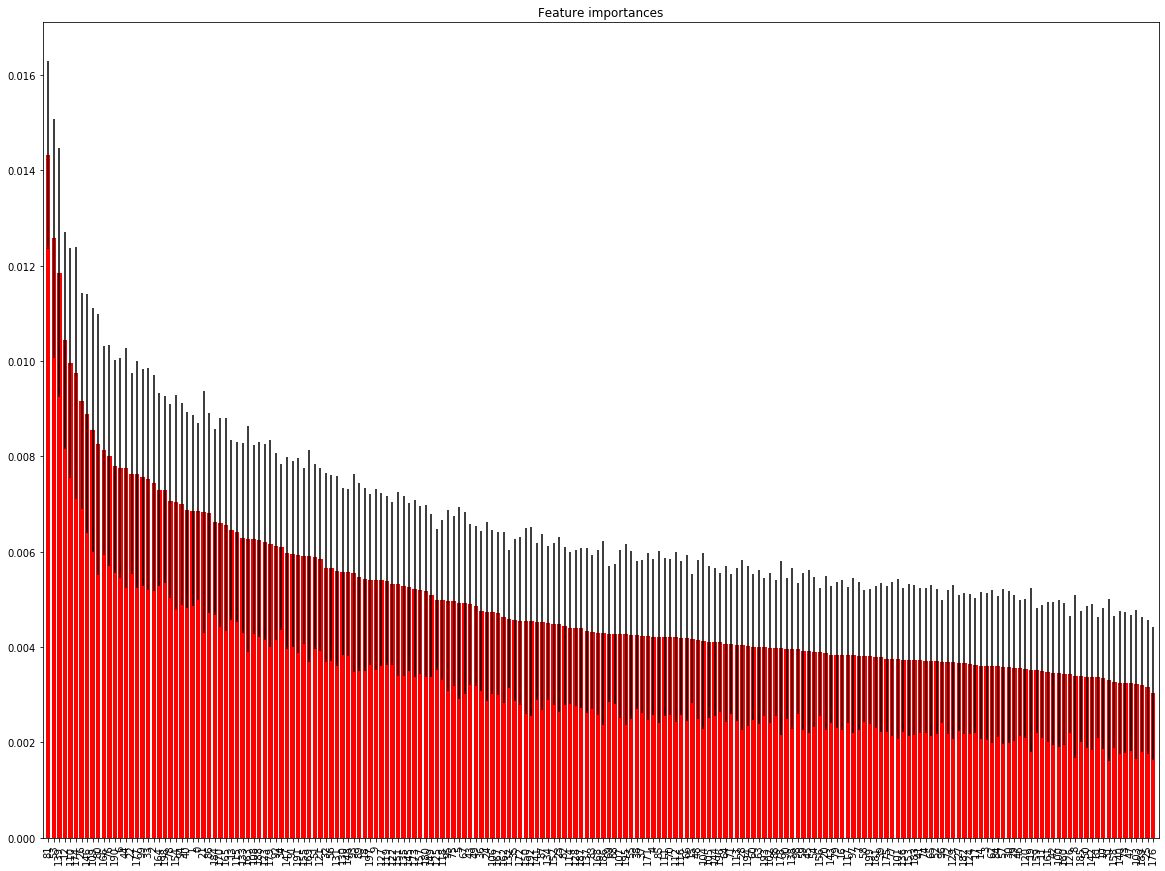

In [12]:
preds = rf.predict(test_features)
pd.crosstab(test_response, preds, rownames=['Actual Value'], colnames=['Predicted Value'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Plot the feature importances of the forest
plt.figure(figsize = (20,15))
plt.title("Feature importances")
plt.bar(range(test_features.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(test_features.shape[1]), indices, rotation='vertical')
plt.xlim([-1, test_features.shape[1]])
plt.show()

In [26]:
importances.min()

0.003029442174168279

Text(0, 0.5, 'Density')

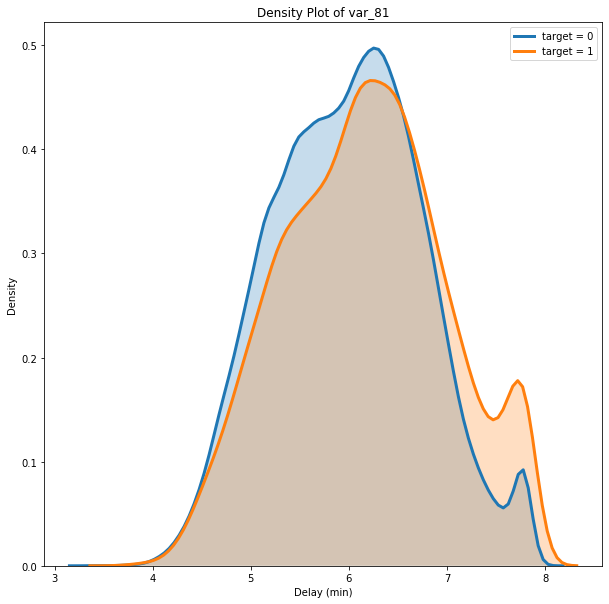

In [27]:
plt.figure(figsize = (10,10))
sns.distplot(train_df.loc[train_df['target'] == 0,'var_81'],hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "target = 0")
sns.distplot(train_df.loc[train_df['target'] == 1,'var_81'],hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "target = 1")

plt.title('Density Plot of var_81')
plt.xlabel('Delay (min)')
plt.ylabel('Density')

## Hyperparameter Tuning

In [58]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.sum(errors)/test_labels.size
    accuracy = 100 - mape
    fpr, tpr, thresholds = roc_curve(test_labels, predictions)
    plt.figure(figsize = (10,10))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.show()
    decision_boundary = 0.18
    predictions[predictions < decision_boundary] = 0
    predictions[predictions >= decision_boundary] = 1
    conf_mat = confusion_matrix(test_labels, predictions)
    print('Model Performance')
    print(conf_mat)
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

## Random search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(train_features, train_response);

In [ ]:
rf_random.best_params_

In [ ]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

In [32]:
best_params_random = joblib.load("../project/best_params_rf.pkl")
best_estimator_random= joblib.load("../project/best_estimator_rf.pkl")
best_params_random

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': False}

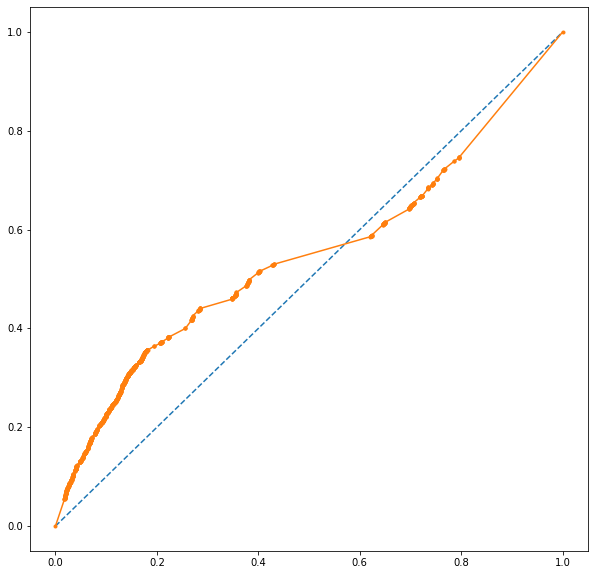

Model Performance
[[13793  1994]
 [ 1265   463]]
Accuracy = 83.76%.


In [59]:
random_accuracy = evaluate(best_estimator_random, test_features, test_response)

## Grid search 1

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [20, 30, 40],
    'max_features': [2, 3],
    'min_samples_leaf': [4, 5, 6],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [1800, 2000, 2200]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)
grid_search.fit(train_features, train_labels);

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

### Grid search 2

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [110, 120, None],
    'max_features': [3, 4],
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [10],
    'n_estimators': [75, 100, 125]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search_final = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                 cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

grid_search_final.fit(train_features, train_labels);

In [ ]:
grid_search_final.best_params_

In [ ]:
best_grid_final = grid_search_final.best_estimator_
grid_final_accuracy = evaluate(best_grid_final, test_features, test_labels)

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))